In [1]:
!pip install -q catboost

In [2]:
!pip install -q optuna

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RandomizedSearchCV,GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import accuracy_score, precision_score,make_scorer, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", message="Dask dataframe query planning is disabled because dask-expr is not installed.")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
train = pd.read_csv('/content/train_fin.csv')
test = pd.read_csv('/content/test_fin.csv')
Submission = pd.read_csv('/content/Sub.csv')

In [5]:
train.head()

,FarmID,category,Crop,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,...,Crop_Season,Crop_District,log_cropbiomass,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
0,1326576,Healthy,0.281162,0.167641,0.003017,97,54,0.16387,0.163587,0.281162,...,0.207241,0.109655,8.563695,17,97,63.75,36.178953,70.5,255,-0.757028
1,1326577,Healthy,0.281162,0.167641,0.003017,82,58,0.16387,0.163587,0.281162,...,0.207241,0.109655,8.467162,15,94,62.25,34.874776,70.0,249,-1.035064
2,1326578,Healthy,0.281162,0.167641,0.003017,92,91,0.16387,0.163587,0.281162,...,0.207241,0.109655,9.032648,20,99,75.50,37.170777,91.5,302,-1.944015
3,1331836,Diseased,0.281162,0.167641,0.003017,91,52,0.16387,0.163587,0.281162,...,0.207241,0.109655,8.462103,16,92,62.75,36.307713,71.5,251,-0.777877
4,1326579,Diseased,0.281162,0.167641,0.003017,94,55,0.16387,0.163587,0.281162,...,0.207241,0.109655,8.550628,20,97,66.50,36.428011,74.5,266,-0.729500


In [6]:
test.head()

,FarmID,category,Crop,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,...,Crop_Season,Crop_District,log_cropbiomass,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
0,85197,NaN,0.281162,0.167641,0.043843,81,99,0.117292,0.117575,0.281162,...,0.207241,0.109655,NaN,19,99,70.00,35.042831,81.0,280,-1.635969
1,779677,NaN,0.281162,0.167641,0.043843,91,63,0.117292,0.117575,0.281162,...,0.207241,0.109655,NaN,15,97,66.50,37.394295,77.0,266,-1.192778
2,1331840,NaN,0.281162,0.167641,0.043843,94,89,0.163870,0.163587,0.281162,...,0.207241,0.109655,NaN,15,94,71.50,37.758001,88.5,286,-1.970636
3,483053,NaN,0.281162,0.167641,0.043843,83,78,0.163870,0.163587,0.281162,...,0.207241,0.109655,NaN,17,98,69.00,35.693137,80.5,276,-1.652935
4,542945,NaN,0.281162,0.167641,0.043843,82,53,0.117292,0.117575,0.281162,...,0.207241,0.109655,NaN,18,98,62.75,35.169826,67.5,251,-0.606987


In [7]:
Submission.head()

,ID,Target
0,85197,0
1,779677,0
2,1331840,0
3,483053,0
4,542945,0


In [8]:
train.shape, test.shape, Submission.shape

((7888, 40), (2718, 40), (2718, 2))

In [9]:
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

In [11]:
test = test.drop('category',axis=1)

In [14]:
train = train.drop(['Sub-District','District','Crop_District','FarmID'],axis=1)
test = test.drop(['Sub-District','District','Crop_District','FarmID'],axis=1)

In [16]:
#Changing  target from int to object through mapping
train['category'] = train['category'].map({'Healthy':0, 'Pests':1, 'Diseased':2, 'Stressed':3})

In [18]:
#negative correlation
train.corr()['category'].sort_values()[train.corr()['category'].sort_values() < 0]

In [19]:
#positive correlation
train.corr()['category'].sort_values()[train.corr()['category'].sort_values() > 0]

# Modelling

In [22]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=train.category)):
    # Use .iloc to select rows by position, ensuring alignment with val_idx
    train.iloc[val_idx, train.columns.get_loc('fold')] = fold

train['fold'].value_counts()

,count
fold,
5,789
7,789
6,789
0,789
4,789
1,789
3,789
2,789
9,788


In [23]:
model = RandomForestClassifier(n_estimators=300,max_depth=25,min_samples_split=3,min_samples_leaf=2, random_state=42,n_jobs=-1)



n_splits = train['fold'].nunique()

overall_predictions = np.zeros((len(train), ))
test_predictions = []

for fold in range(n_splits):
    print(f"Validating on Fold: {fold}")
    train_df = train[train['fold'] != fold].drop('fold', axis=1)
    val_df = train[train['fold'] == fold].drop('fold', axis=1)

    X_train = train_df.drop('category', axis=1)
    y_train = train_df['category']
    X_val = val_df.drop('category', axis=1)
    y_val = val_df['category']

    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val).reshape(-1,)

    # Use the validation set's index relative to train to assign predictions
    overall_predictions[val_df.index.get_indexer(val_df.index)] = val_predictions

    test_predictions.append(model.predict_proba(test))
    print(f"Fold {fold + 1} F1 Score: {f1_score(y_val, val_predictions, average='weighted')}")

print(f"Overall F1 Score: {f1_score(train['category'], overall_predictions, average='weighted')}")

Validating on Fold: 0
Fold 1 F1 Score: 0.7460234474017743
Validating on Fold: 1
Fold 2 F1 Score: 0.7490239240447983
Validating on Fold: 2
Fold 3 F1 Score: 0.7460234474017743
Validating on Fold: 3
Fold 4 F1 Score: 0.744765913790277
Validating on Fold: 4
Fold 5 F1 Score: 0.7460234474017743
Validating on Fold: 5
Fold 6 F1 Score: 0.7460234474017743
Validating on Fold: 6
Fold 7 F1 Score: 0.7472449204761193
Validating on Fold: 7
Fold 8 F1 Score: 0.7442501173625186
Validating on Fold: 8
Fold 9 F1 Score: 0.7457128131993815
Validating on Fold: 9
Fold 10 F1 Score: 0.7457128131993815
Overall F1 Score: 0.745606547803753


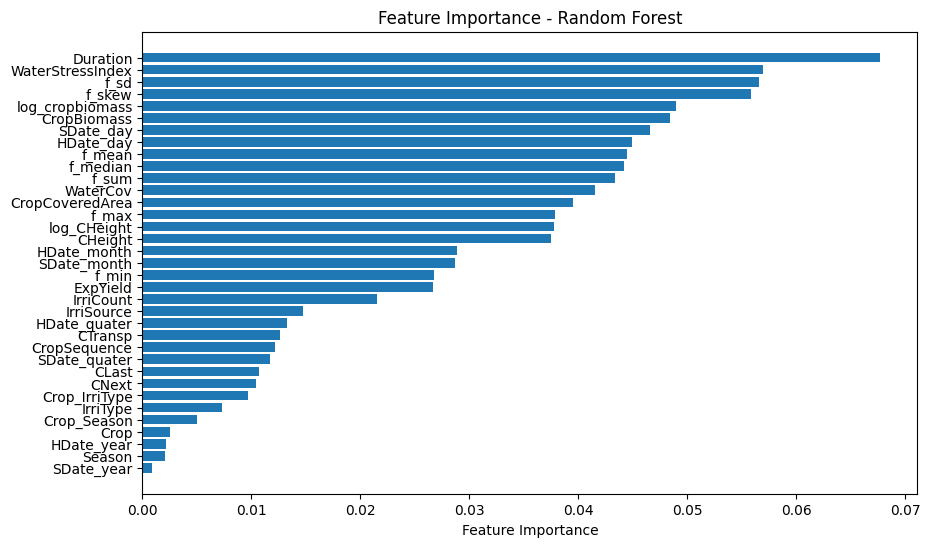

In [31]:
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Random Forest")
plt.show()

In [32]:
mean_preds = np.mean(test_predictions, axis=0)
predicted_classes = np.argmax(mean_preds, axis=1)
len(predicted_classes),test.shape[0]


(2718, 2718)

In [33]:
#remapping to the original classes
class_mapping = {0: 'Healthy', 1: 'Pests', 2: 'Diseased', 3: 'Stressed'}
test_pred = [class_mapping[pred] for pred in predicted_classes]


In [34]:
Submission['Target'] = test_pred

In [37]:
Submission.head()

,ID,Target
0,85197,Healthy
1,779677,Healthy
2,1331840,Healthy
3,483053,Healthy
4,542945,Healthy


In [39]:
Submission.to_csv('Sub_RFall_samples.csv',index=False)